# 1. Holt-Winter ETS model - Detailed

### We are here testing the Holt-WInter ETS model on the whole day. RMSE of forecast vs backtest will help assess the model right

## I. Declarations

In [1]:
# Library Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit

from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings


In [2]:
# Creating list of times to start the prediction
# warnings.filterwarnings("ignore")
time = pd.Timestamp("00:00:00")
time_list = []
time_list.append(str(time)[-8:])

# Adding 15 minutes every time
#for i in range(1):
for i in range(24*4-1):
    time += pd.Timedelta(minutes=15)
    time_list.append(str(time)[-8:])
print(time_list)

['00:00:00', '00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00', '01:30:00', '01:45:00', '02:00:00', '02:15:00', '02:30:00', '02:45:00', '03:00:00', '03:15:00', '03:30:00', '03:45:00', '04:00:00', '04:15:00', '04:30:00', '04:45:00', '05:00:00', '05:15:00', '05:30:00', '05:45:00', '06:00:00', '06:15:00', '06:30:00', '06:45:00', '07:00:00', '07:15:00', '07:30:00', '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00', '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00', '15:15:00', '15:30:00', '15:45:00', '16:00:00', '16:15:00', '16:30:00', '16:45:00', '17:00:00', '17:15:00', '17:30:00', '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:00', '19:00:00', '19:15:00', '19:30:00', '19:45:00', '20:00:00', '20:15:00', '20:30:00', '20

## II. Model pipe

In [3]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', 'additive', None]
    d_params = [True, False]
    s_params = ['add', 'mul', 'additive', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            t,d,s,p,b,r = configurations[i]

            # define model
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

            # predict n values, the length of test arry
            pred = model.predict(start=len(train)+1,end=len(test)+len(train))
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            pass
    return(best_config, best_rmse)

In [4]:
def model_generation(time, time_step, config):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])

    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    # This will be our performance indicator
    

    cfg_list = config
    
    # B. Finding the best parameters over one periode
    best_parameters, best_rmse = exp_smoothing_forecast_grid_search(train, test, cfg_list)
    # Loading the best parameters found befor
    t,d,s,p,b,r = best_parameters

    # Creating the model on full time serie
    model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
    

    # C. Training on full time serie to optimize before prediction¶

    # Creating the model on full time serie, using best parameters
    model = ExponentialSmoothing(time_serie, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

    # predicting on all time serie for global RMSE
    pred_model = model.predict(1,end=len(time_serie))
    RMSE_test = measure_rmse(time_serie,pred_model)

    sarima_model = SARIMAX(time_serie, order=(1, 1, 1), seasonal_order=(2, 1, 0, 60), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))
    final_prediction_sarima = model_sarima.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))

    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_first_run","forecast_optimized","forecast_optimized_round","backtest","sarima","sarima_round"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    
    df_assessement.sarima = (np.concatenate((time_serie, final_prediction_sarima), axis = 0))
    df_assessement.sarima_round = df_assessement.sarima.apply(lambda x:round(x,0))
    
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso["date"]
    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]

    # V. SYNTHSIS

    # Time to run

    elapsed = timeit.default_timer() - start_time


    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters, elapsed]
    return results

In [5]:
# Setting the configurations to test 

config = exp_smoothing_configs(seasonal=[60])

In [6]:
df_result = pd.read_csv("/home/exalis/GitHub/velib-prediction/velib-prediction/6. Model Assessement/6.1. ETS_prod_results_best_parameters.csv", decimal=",")

In [7]:
def model_pred (time):
    
    df_pred = pd.read_csv("/home/exalis/GitHub/velib-prediction/velib-prediction/6. Model Assessement/6.3 Projections2.csv", decimal=",")

    df_pred["LSTM_pred_split"] = df_pred.LSTM_pred.apply(lambda x: x.split(","))

    for i in range(0, df_pred.shape[0]):
        df_pred["LSTM_pred_split"][i] = [float(j) for j in df_pred["LSTM_pred_split"][i]]
    
    df_pred["XGBoost_pred_split"] = df_pred.XGBoost_pred.apply(lambda x: x.split(","))
    
    for i in range(0, df_pred.shape[0]):
        df_pred["XGBoost_pred_split"][i]
        L = df_pred["XGBoost_pred_split"][i]
        L = [x for x in L if x is not ""]
        df_pred["XGBoost_pred_split"][i] = [round(float(j[:8]),0) for j in L]
    
    time_index = df_pred[df_pred["hour"]== time].index[0]
    
    lstm =  df_pred["LSTM_pred_split"][time_index]
    xgboost = df_pred["XGBoost_pred_split"][time_index]
    
    return lstm, xgboost
    

## III. Exploring the output

We will produce here graphics to look in detail at the results

In [16]:
def model_generation_viz(time, time_step, best_parameters):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])

    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]
    
    
    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    # This will be our performance indicator
    
    # Loading the best parameters found befor
    t,d,s,p,b,r = best_parameters

    
    

    # C. Training on full time serie to optimize before prediction¶

    # Creating the model on full time serie, using best parameters
    model = ExponentialSmoothing(time_serie, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
    model_sarima = SARIMAX(time_serie, order=(1, 1, 1), seasonal_order=(2, 1, 0, 60), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    # predicting on all time serie for global RMSE
    pred_model = model.predict(1,end=len(time_serie))
    RMSE_test = measure_rmse(time_serie,pred_model)


    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))
    final_prediction_sarima = model_sarima.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))
    lstm , xgboost = model_pred(target_start)

    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_optimized","forecast_optimized_round","backtest","lstm","xgboost","sarima","sarima_round"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    
    df_assessement.sarima = (np.concatenate((time_serie, final_prediction_sarima), axis = 0))
    df_assessement.sarima_round = df_assessement.sarima.apply(lambda x:round(x,0))
    
    df_assessement.lstm = (np.concatenate((time_serie, lstm), axis = 0))
    df_assessement.xgboost = (np.concatenate((time_serie, xgboost), axis = 0))
    
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso["date"]
    df_assessement.head()
    # Making a synthetic dataset for easier visualisation

    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]
    start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
    end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

    index_date = pd.date_range(start=start_date, end=end_date, freq="T")
    df_assessement_small.index = index_date
    df_assessement_small.pop("date")
    df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
    
 #   lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
    
    # V. SYNTHSIS
    
    # Graphic visualisation of the prediction

# Setting prediction boundary
    # Calculating lower and upper bounds for ulterior use

# Calculating lower and upper bounds for ulterior use
    
    # Time to run
    
    df_assessement_small.actual[-time_variation:] = None
    df_assessement_small.backtest[:-time_variation-1] = None
    df_assessement_small.lstm[:-time_variation-1] = None
    df_assessement_small.forecast_optimized_round[:-time_variation-1] = None
    df_assessement_small.lstm[:-time_variation-1] = None
    df_assessement_small.xgboost[:-time_variation-1] = None

    return df_assessement_small


# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

In [24]:
i=27
print(df_result.hour[i])

08:00:00


In [25]:
# Generating all availiable graphics
i=27
print(df_result.hour[i])
param = [df_result.t[i], df_result.d[i], df_result.s[i], df_result.p[i], df_result.b[i], df_result.r[i]]

df_assessement_small = model_generation_viz(df_result.hour[i], 30, param)

08:00:00


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [26]:
df_assessement_small

,actual,forecast_optimized,forecast_optimized_round,backtest,lstm,xgboost,sarima,sarima_round,day_before
2020-01-29 07:31:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,13.0
2020-01-29 07:32:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,13.0
2020-01-29 07:33:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,13.0
2020-01-29 07:34:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:35:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:36:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:37:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:38:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:39:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0
2020-01-29 07:40:00,17.0,17.000000,NaN,NaN,NaN,NaN,17.000000,17.0,12.0


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in greater_equal
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()


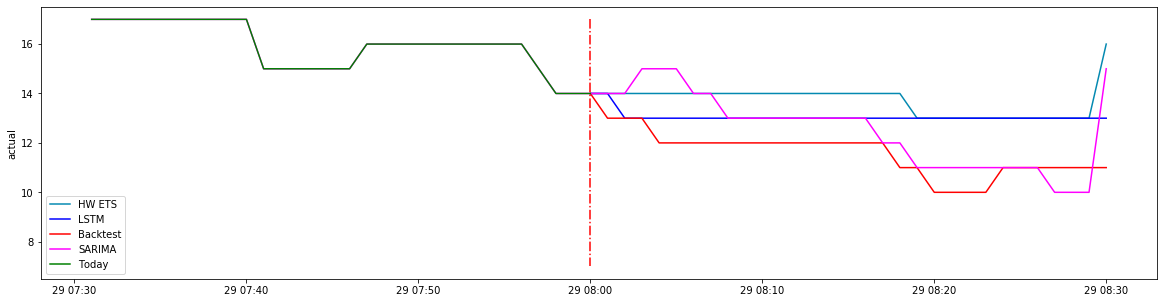

In [31]:
time_variation = 30
# Graphic visualisation of the prediction
lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
#Removing actual and backtest data on projection time for better visualisation

# Graphic visualisation of the prediction
fig, ax = plt.subplots(figsize=(20,5))
#    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="#0489B1",label="HW ETS")    
# ax = sns.lineplot(x=df_assessement_small.index, y="xgboost",data=df_assessement_small, color="#8A0868",label="XGBoost") 
ax = sns.lineplot(x=df_assessement_small.index, y="lstm",data=df_assessement_small, color="blue",label="LSTM")
ax = sns.lineplot(x=df_assessement_small.index, y="backtest",data=df_assessement_small, color="red",label="Backtest") 
    
ax = sns.lineplot(x=df_assessement_small.index, y="sarima_round",data=df_assessement_small, color="#FF00FF",label="SARIMA")
ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today") 
x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
ax = plt.plot(x1, y1, linestyle="dashdot", color="red")

plt.show()

# Loop version

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

error at 29
error at 30


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

error at 34


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

error at 37


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

error at 39


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


error at 44


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

error at 66


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

error at 70
error at 71


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(k

error at 75


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core

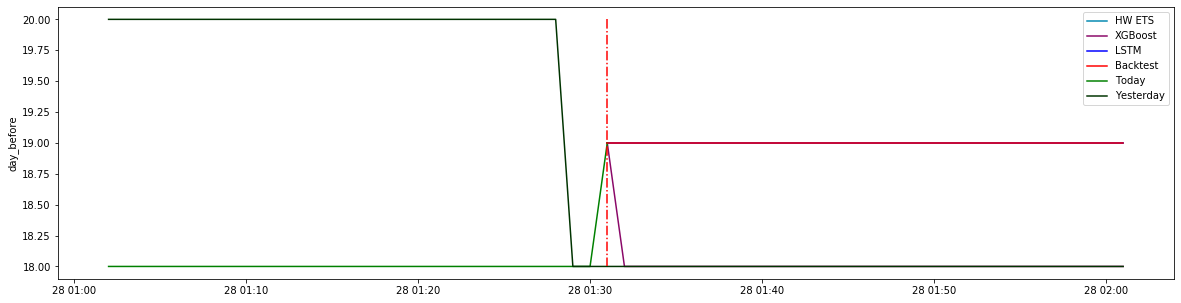

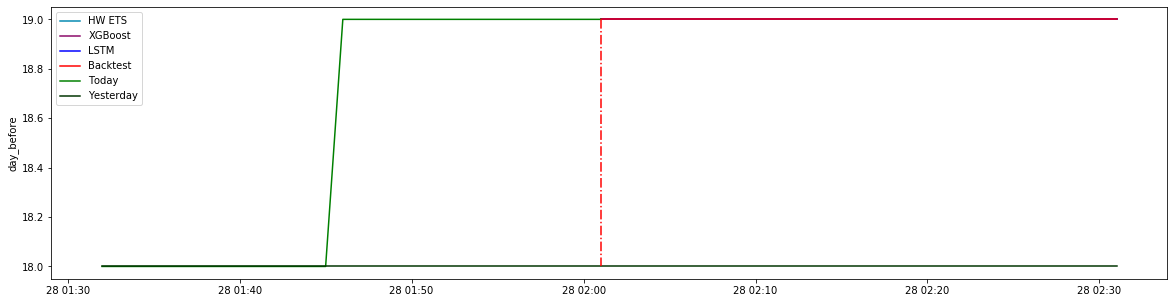

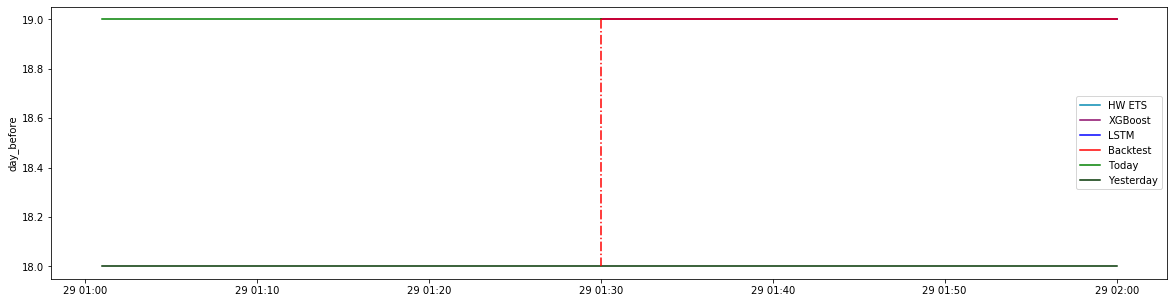

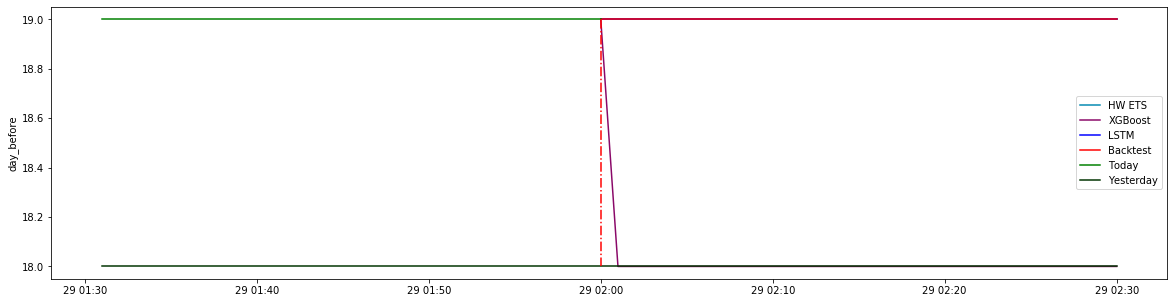

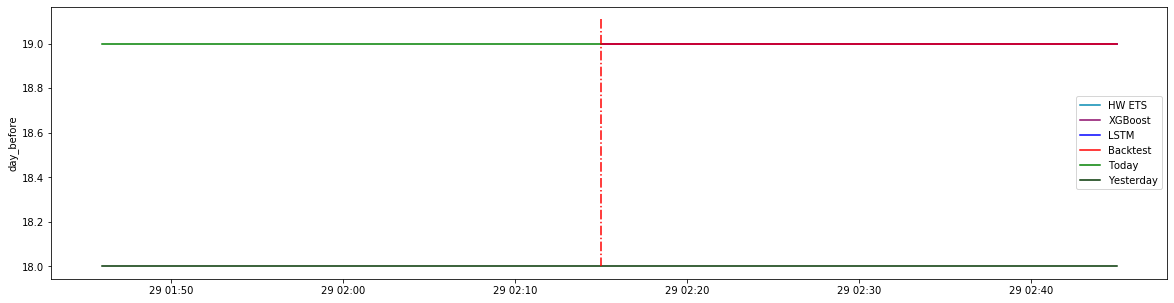

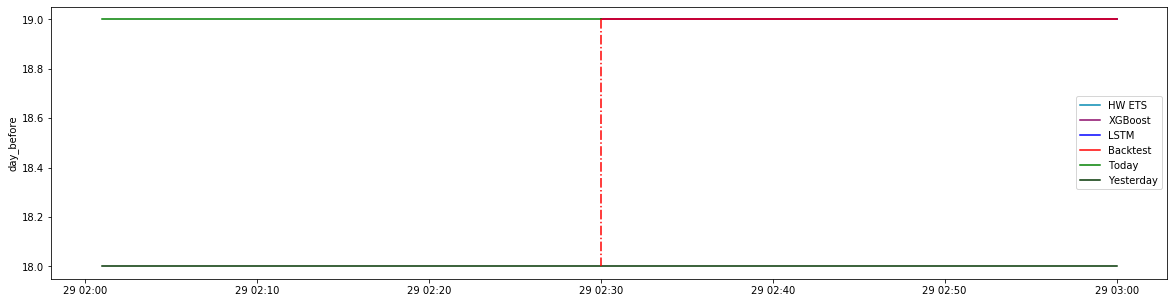

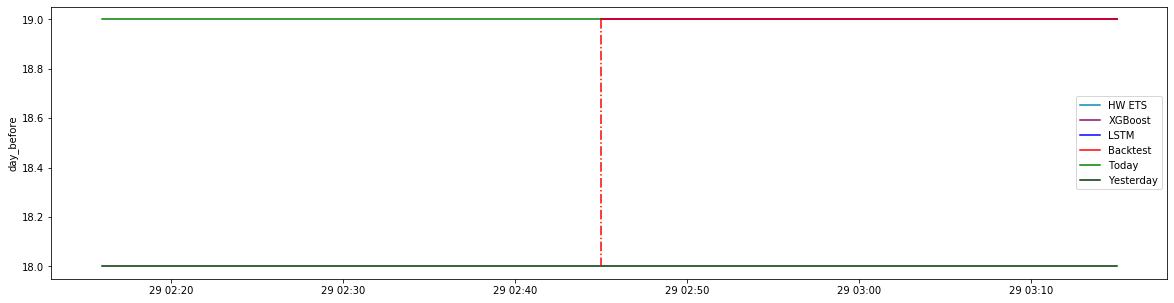

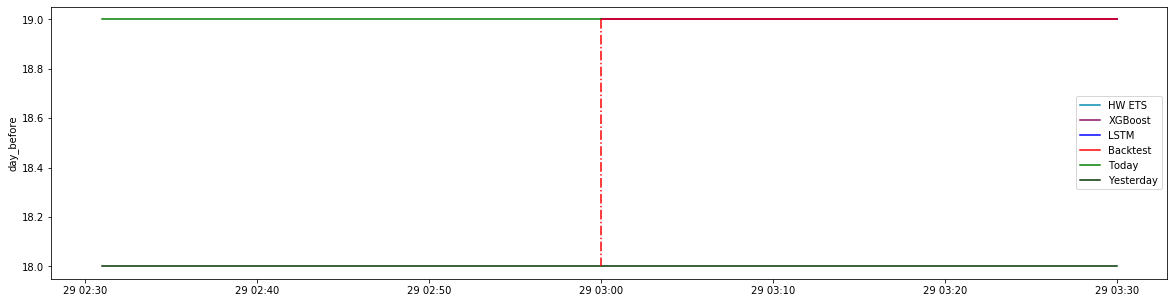

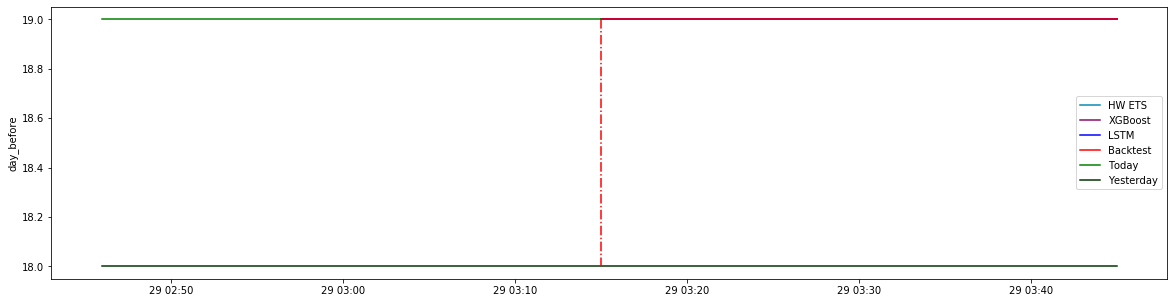

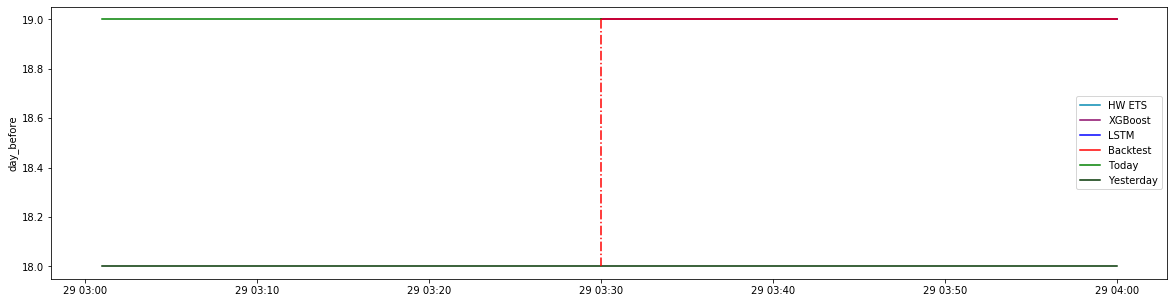

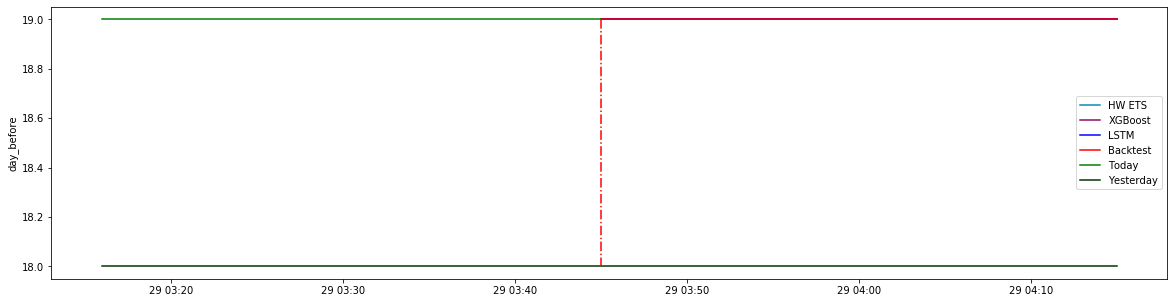

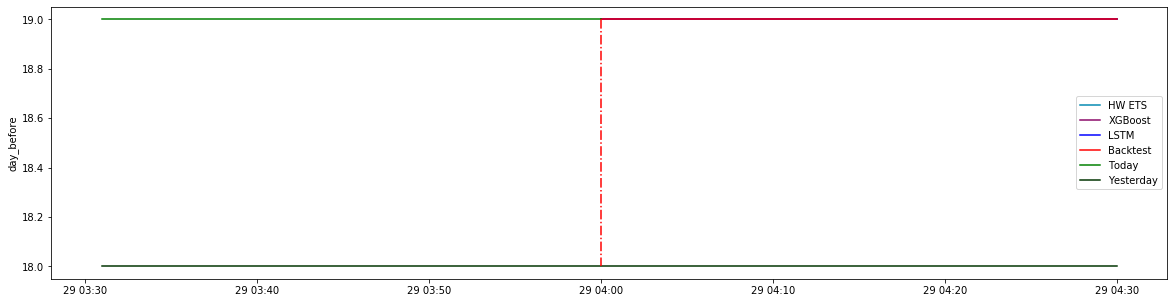

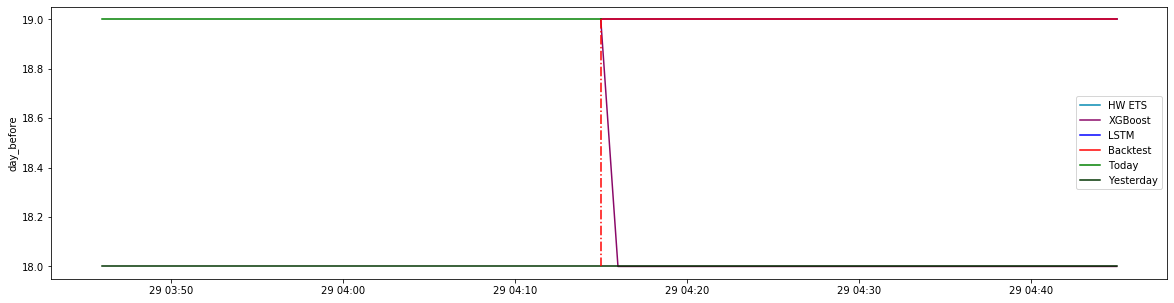

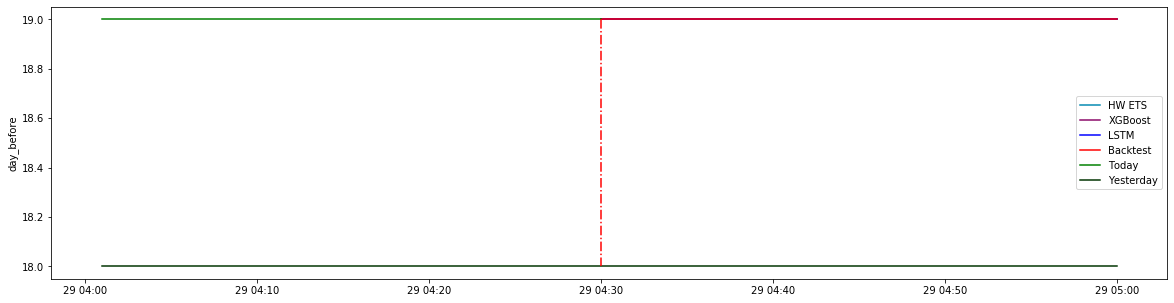

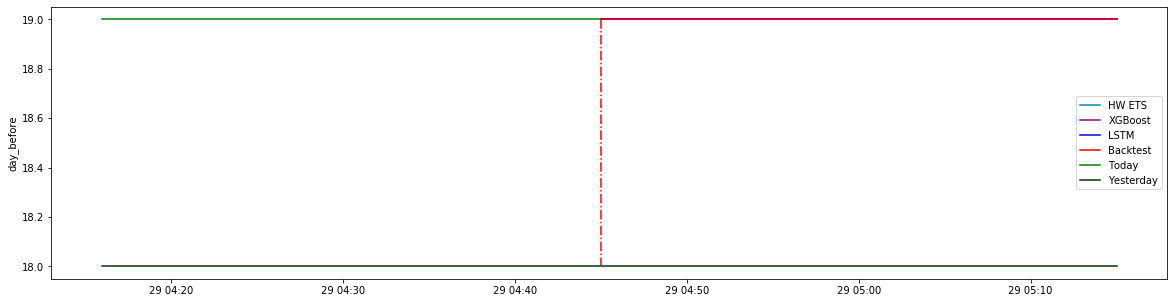

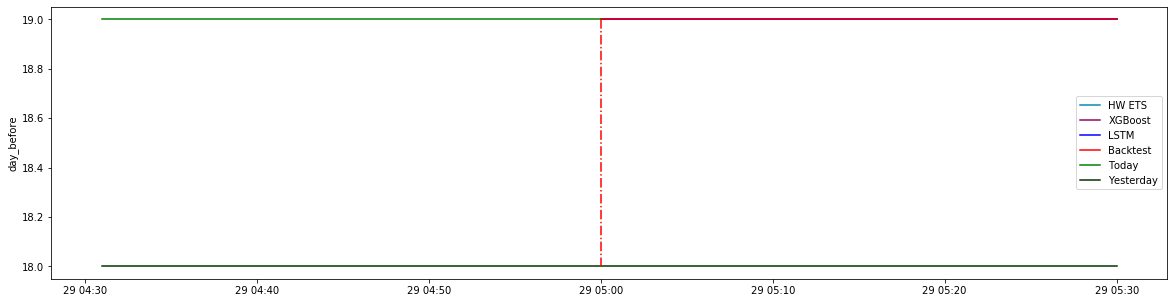

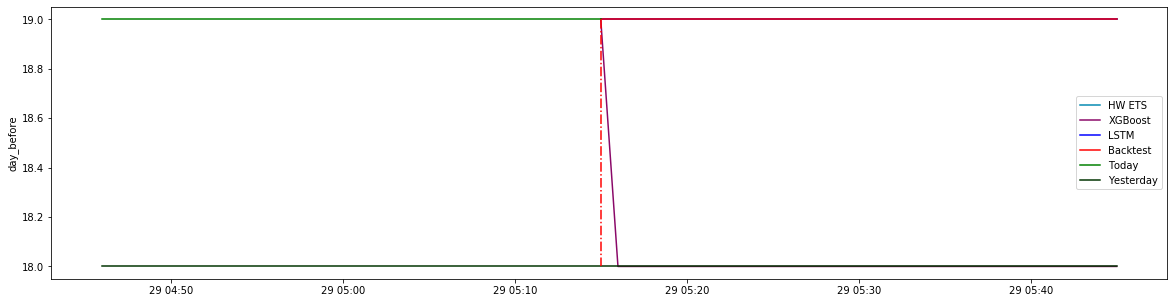

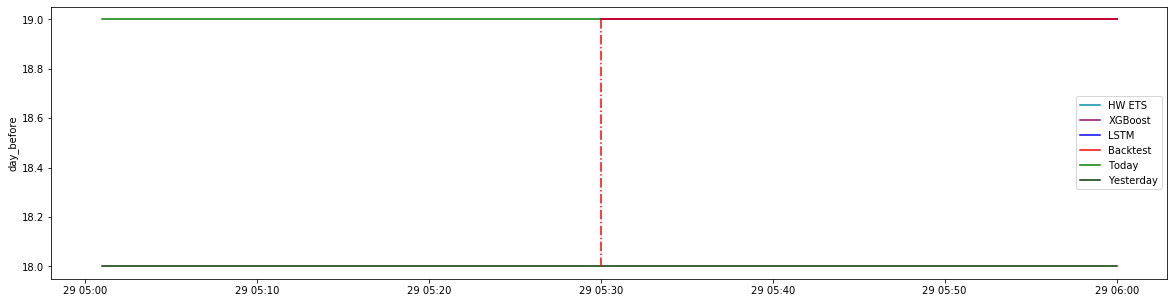

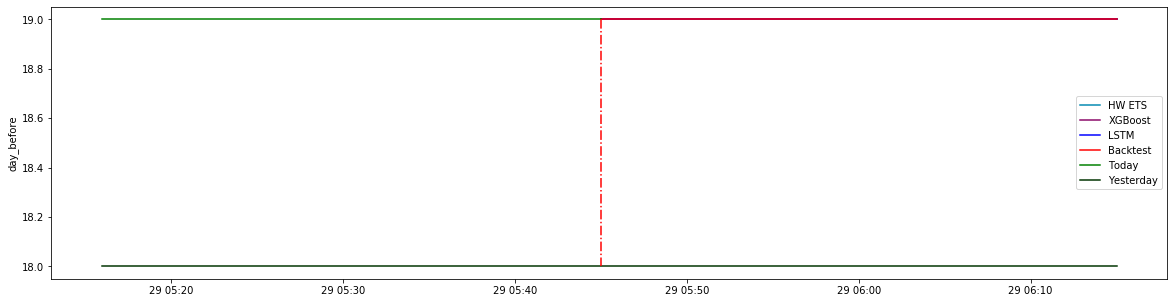

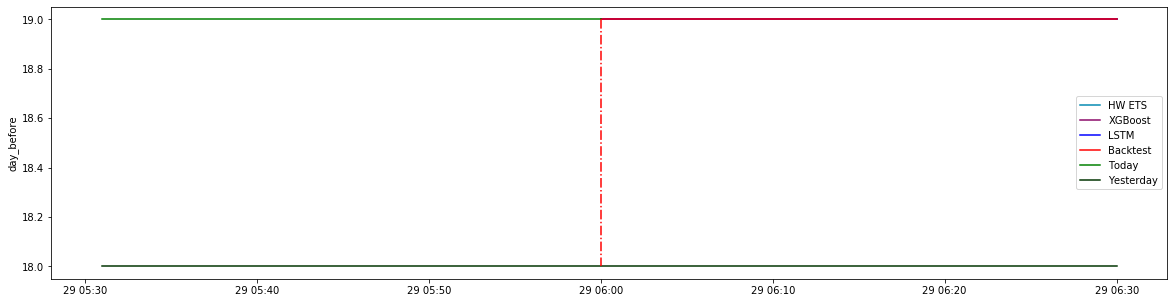

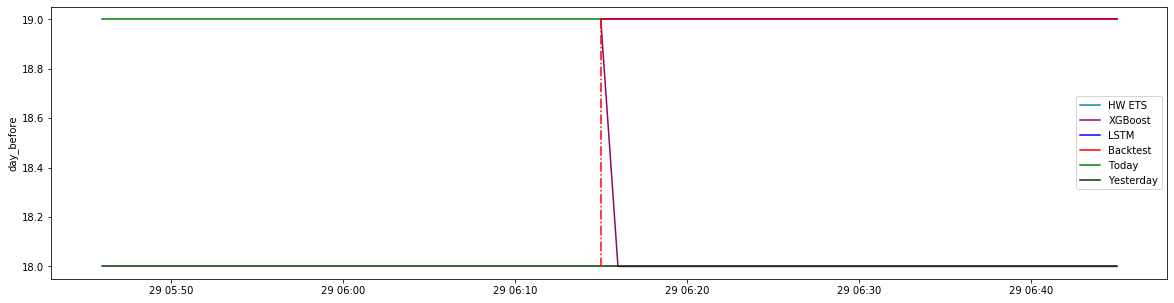

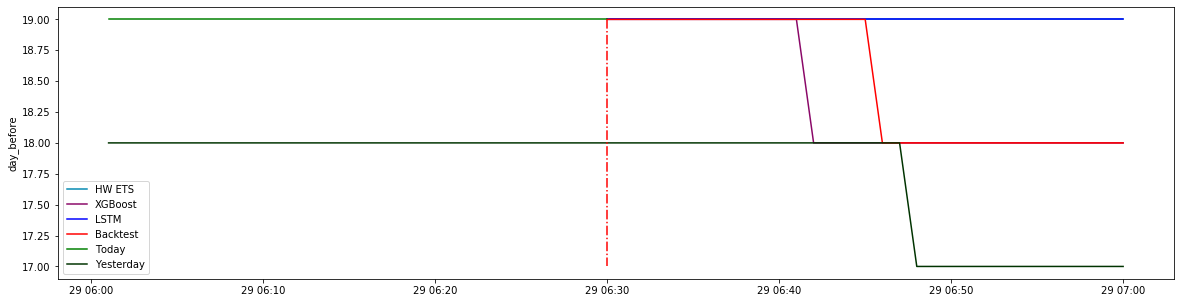

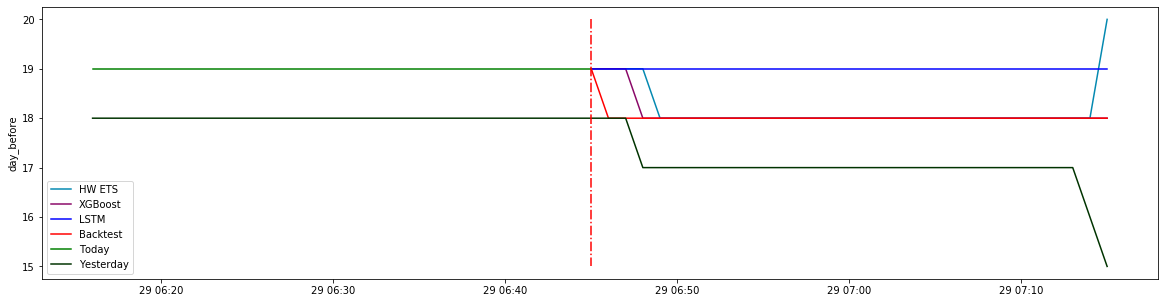

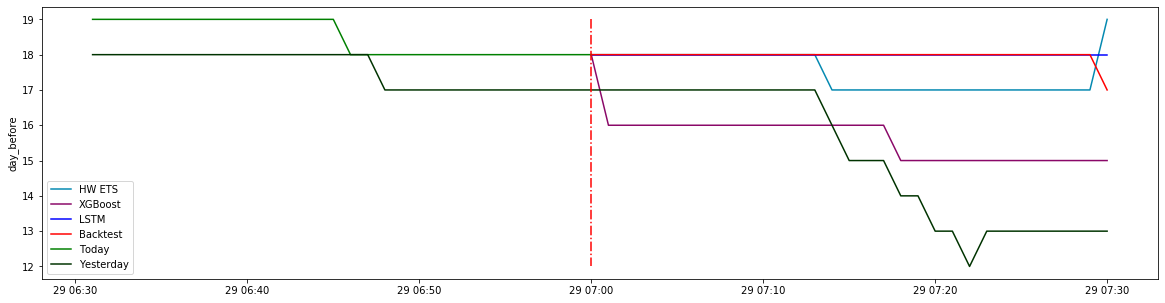

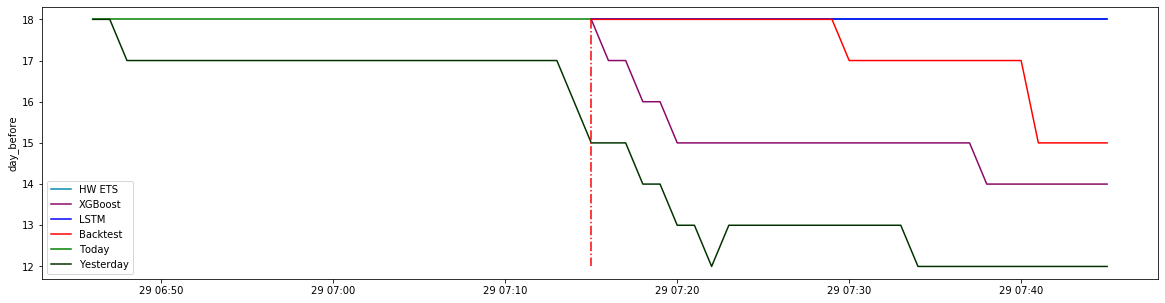

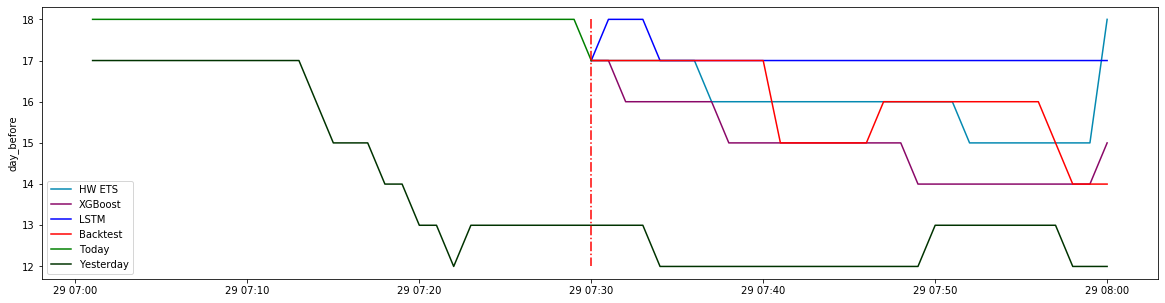

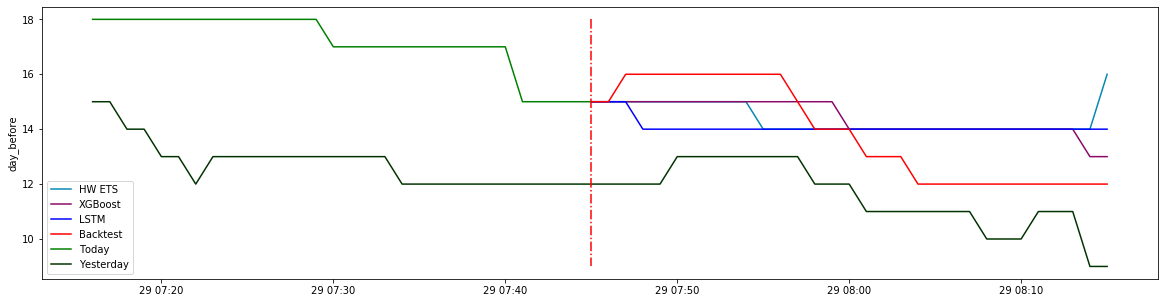

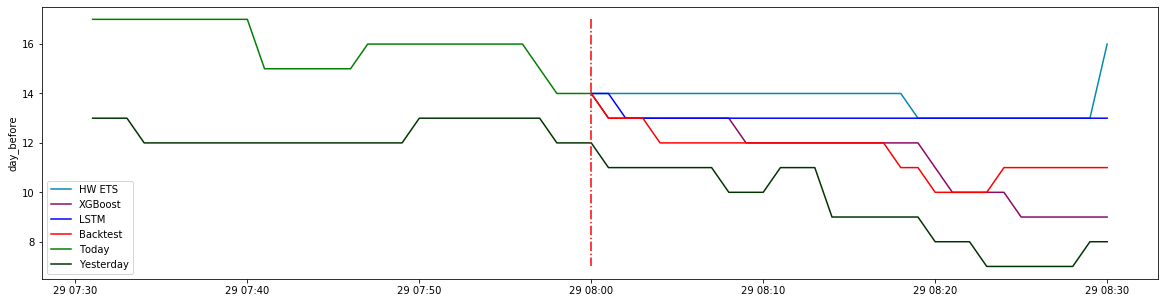

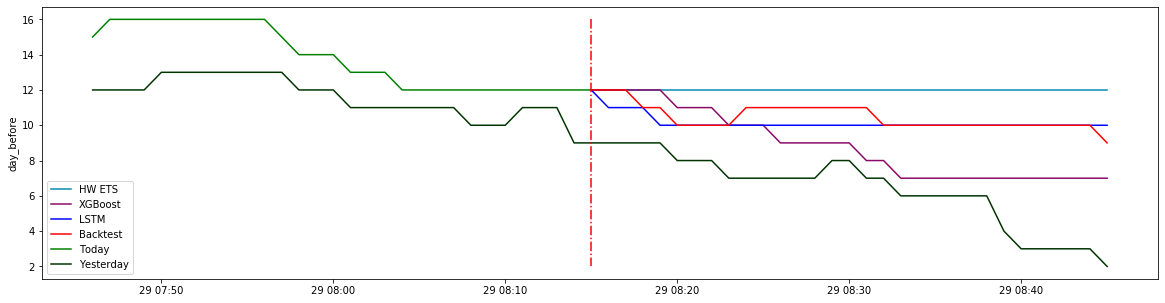

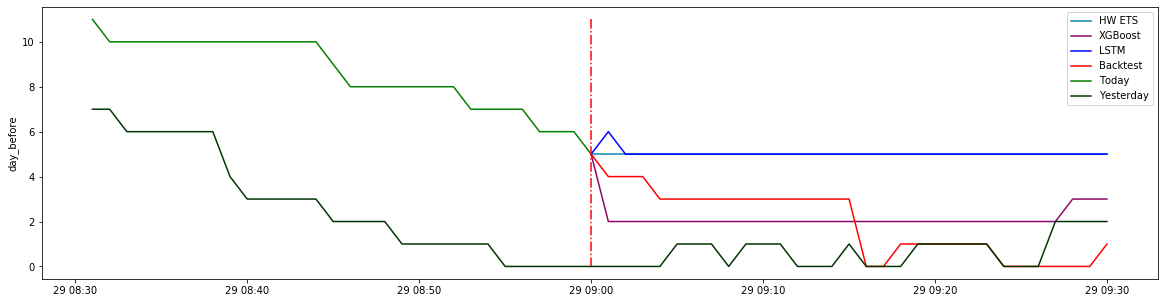

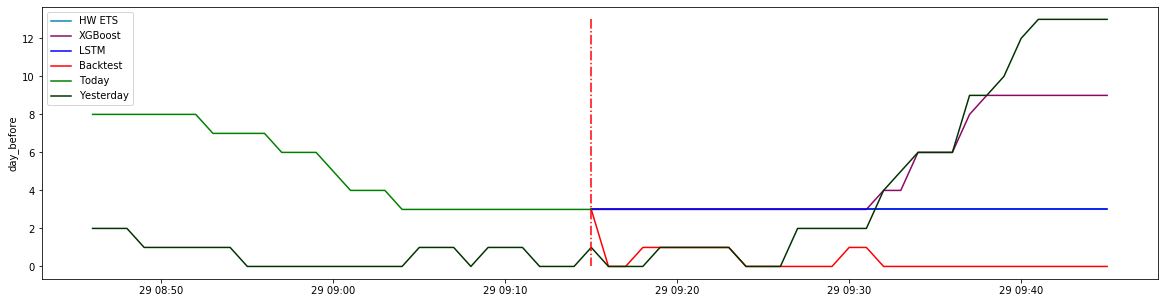

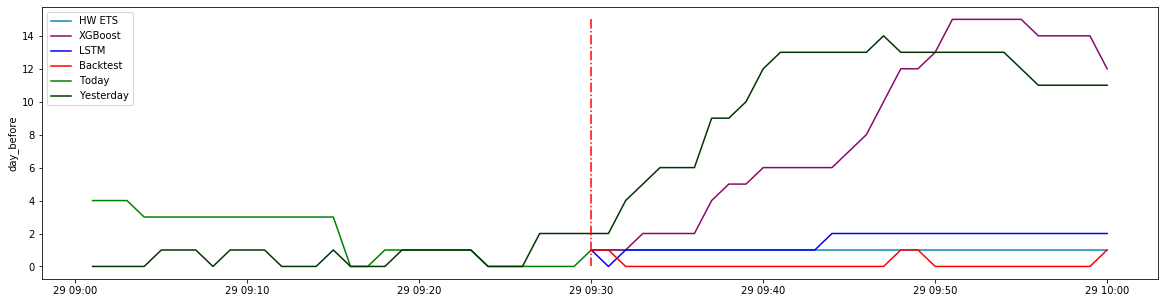

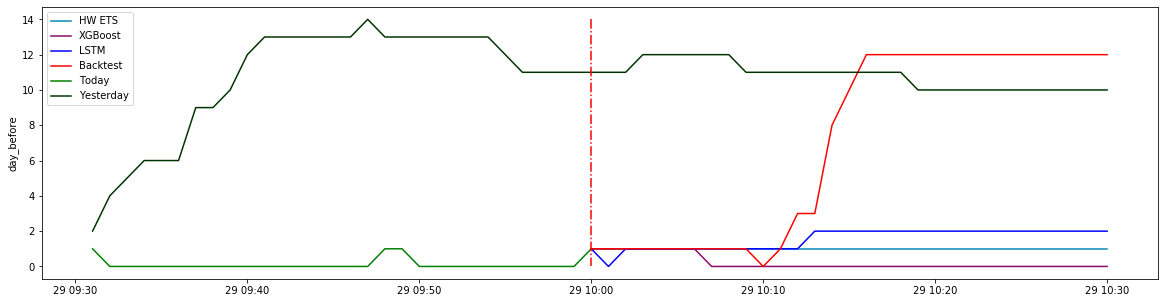

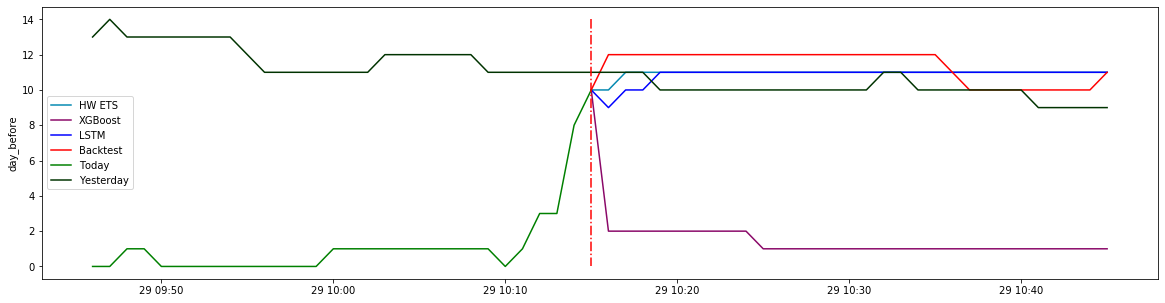

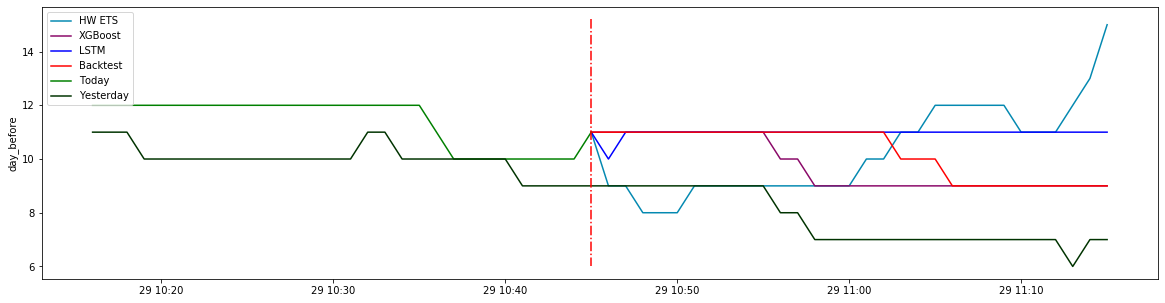

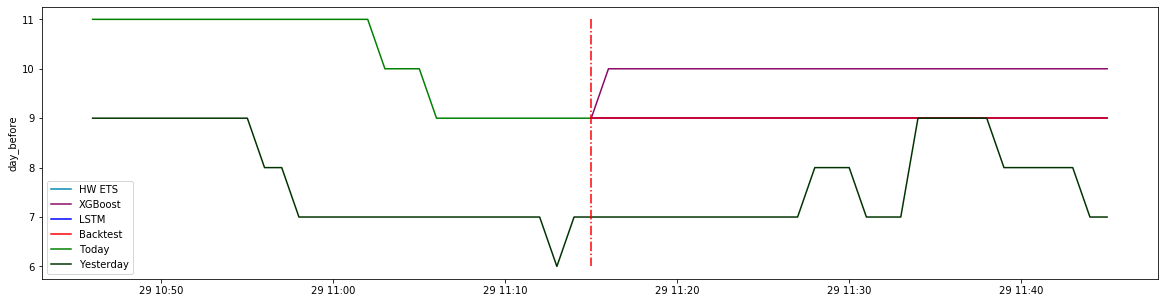

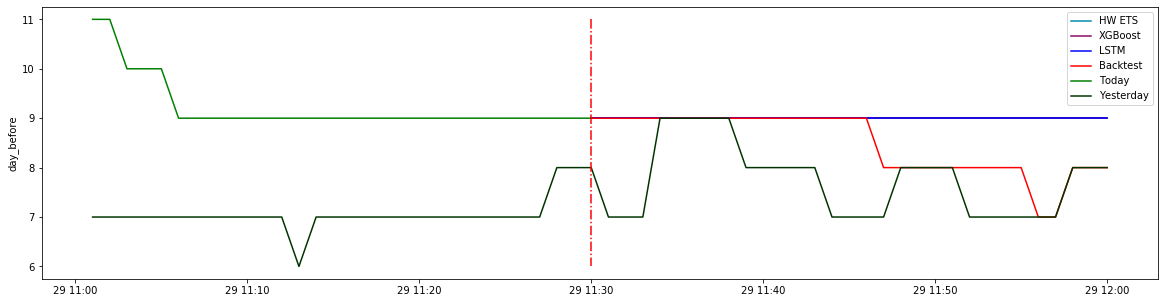

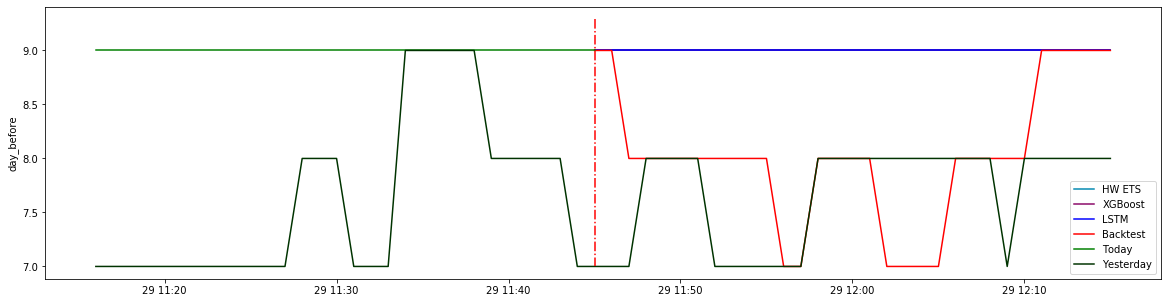

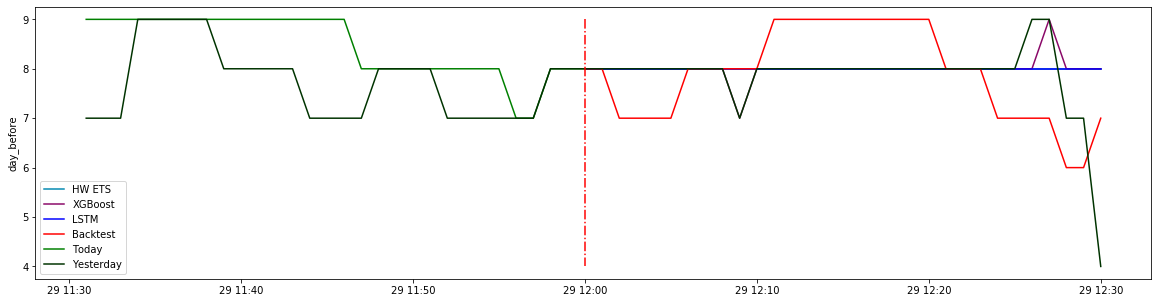

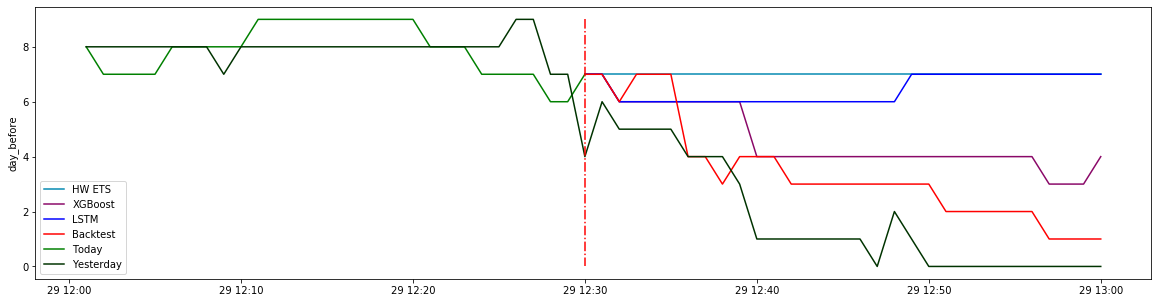

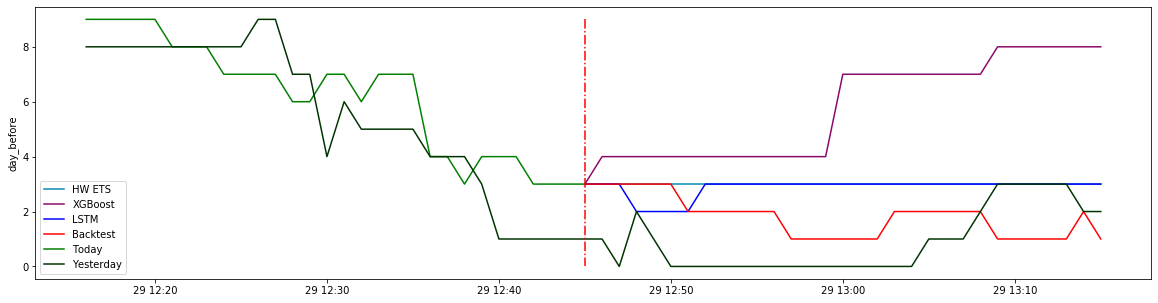

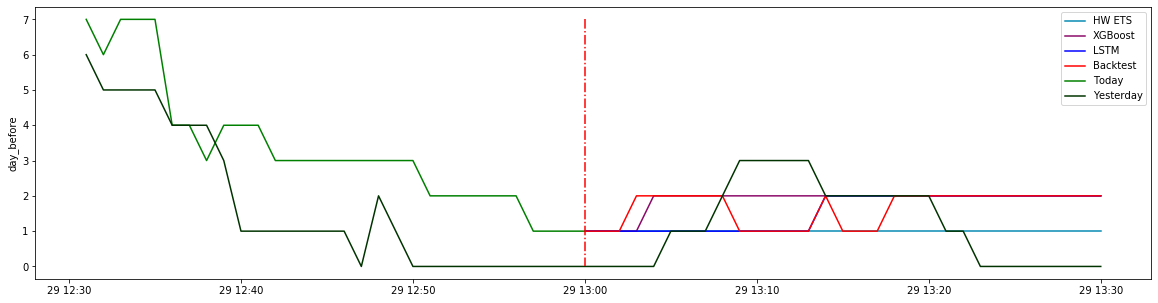

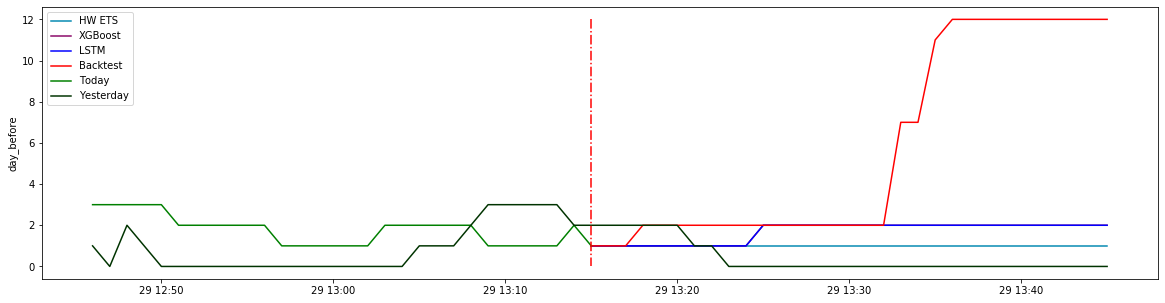

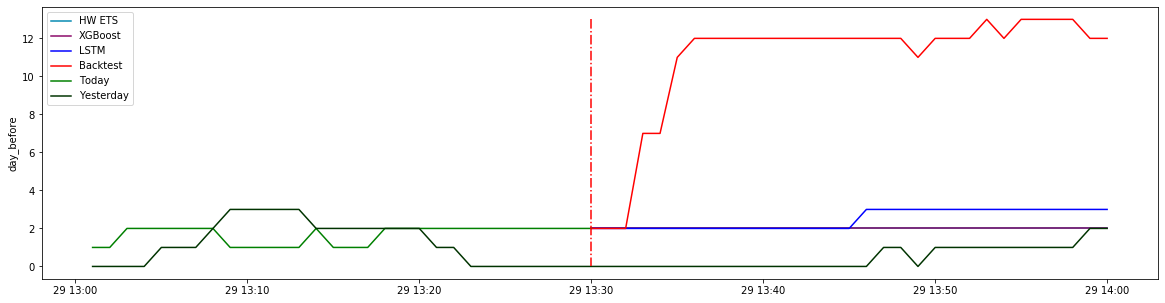

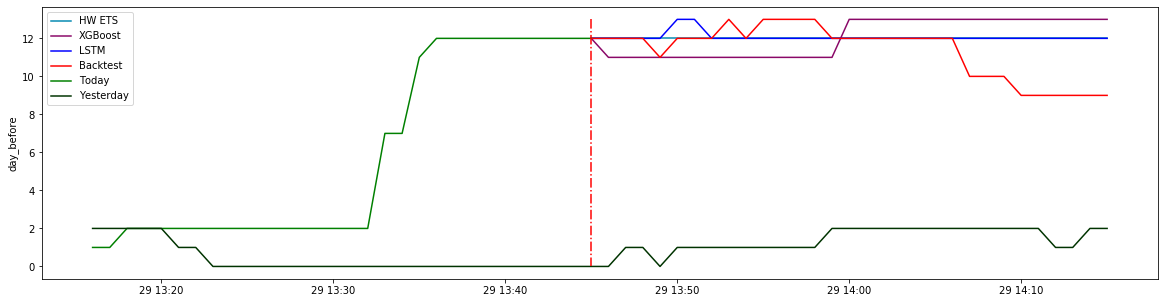

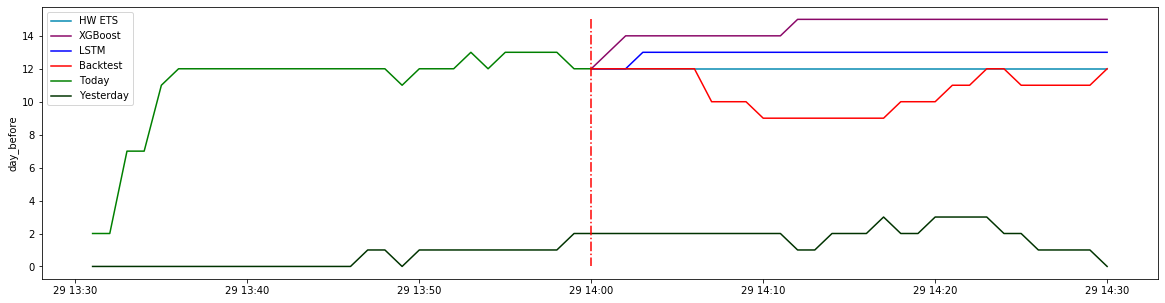

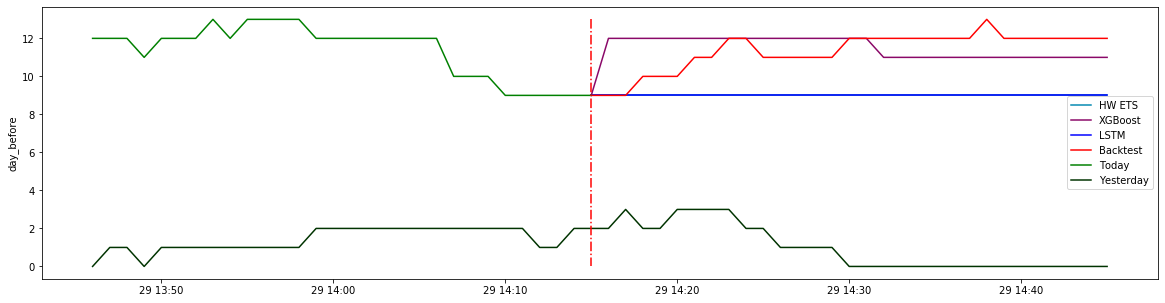

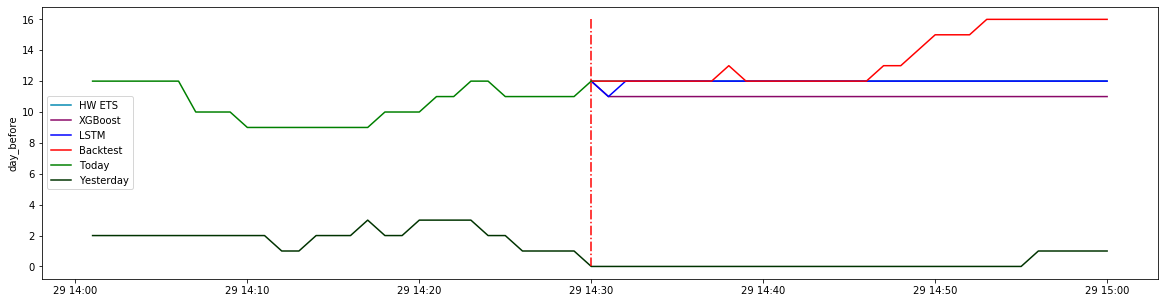

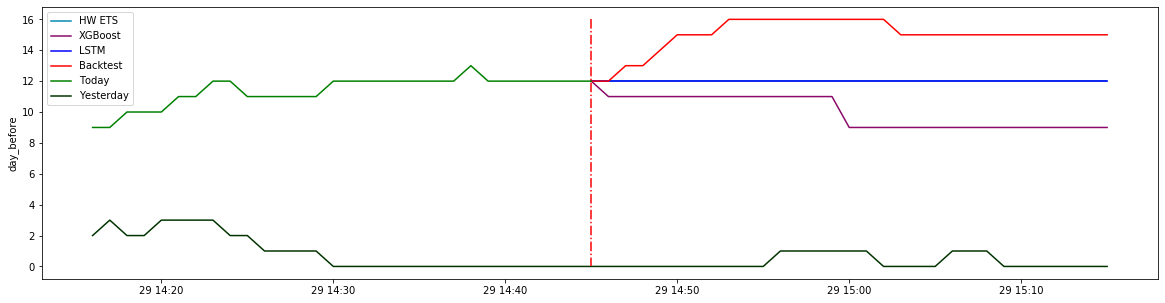

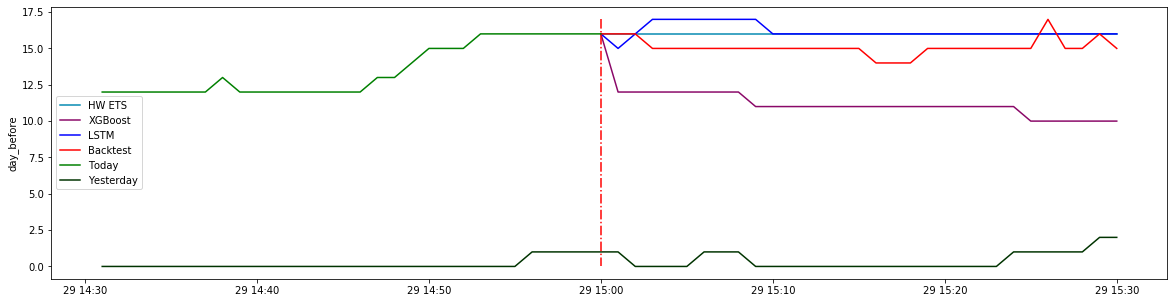

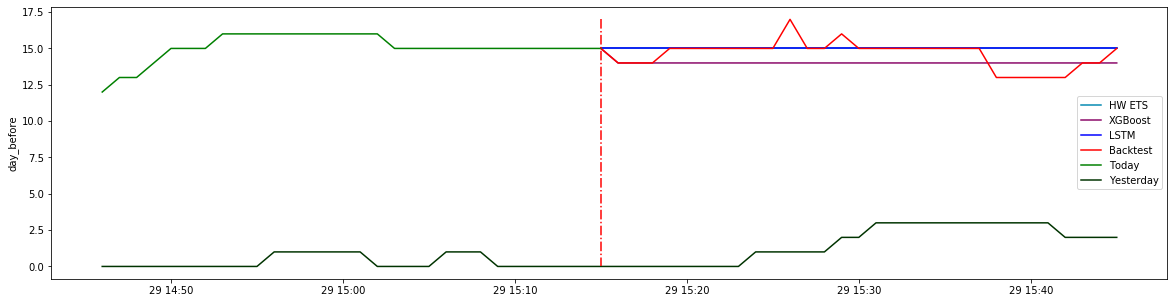

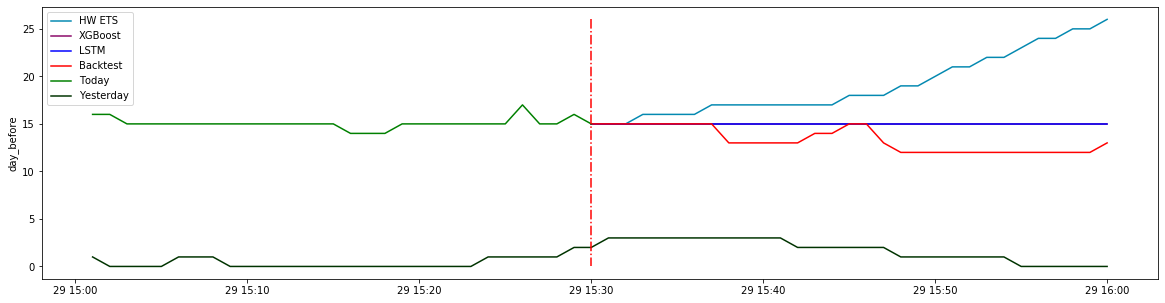

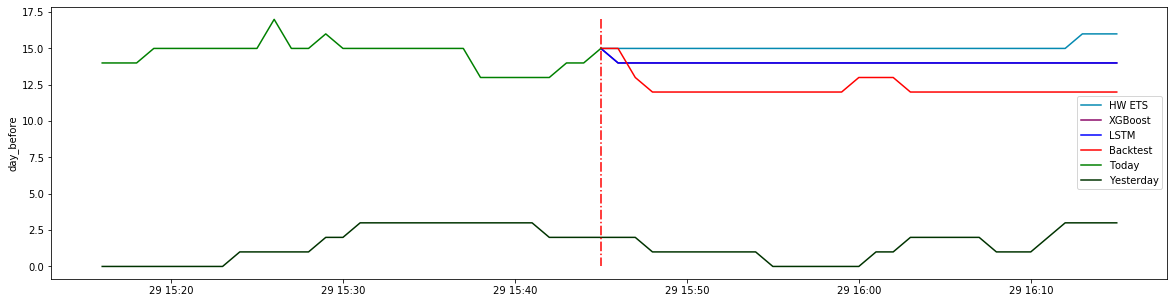

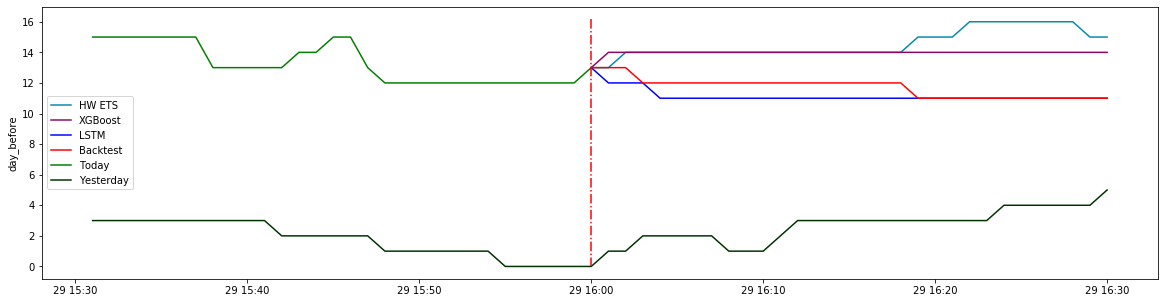

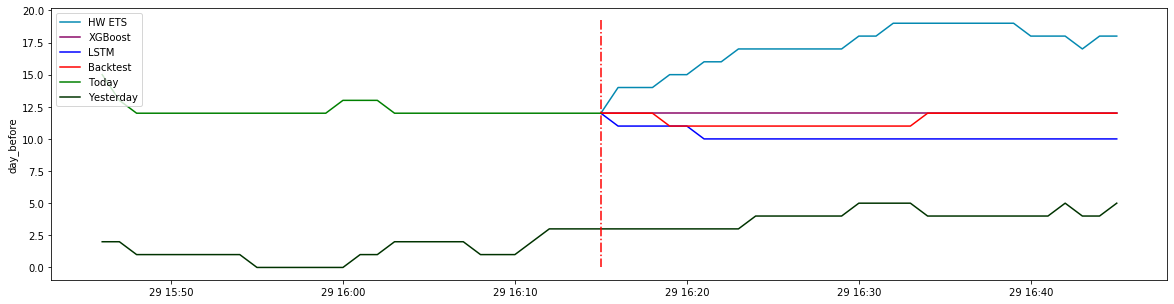

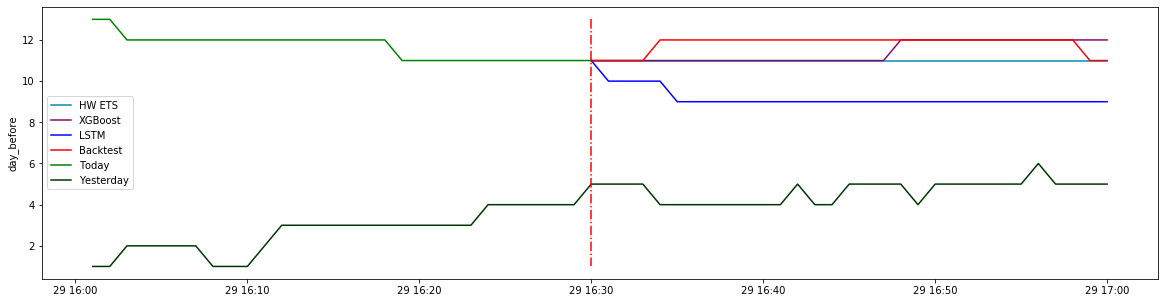

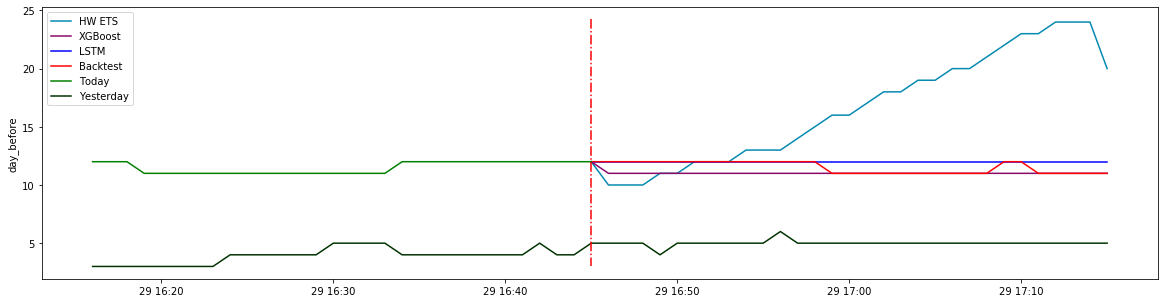

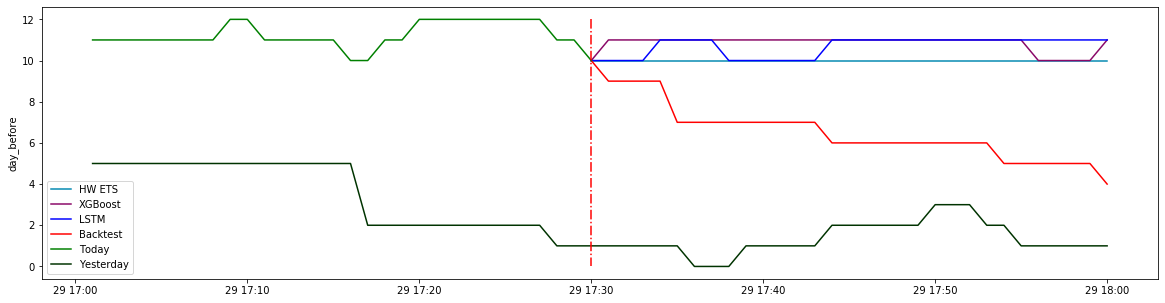

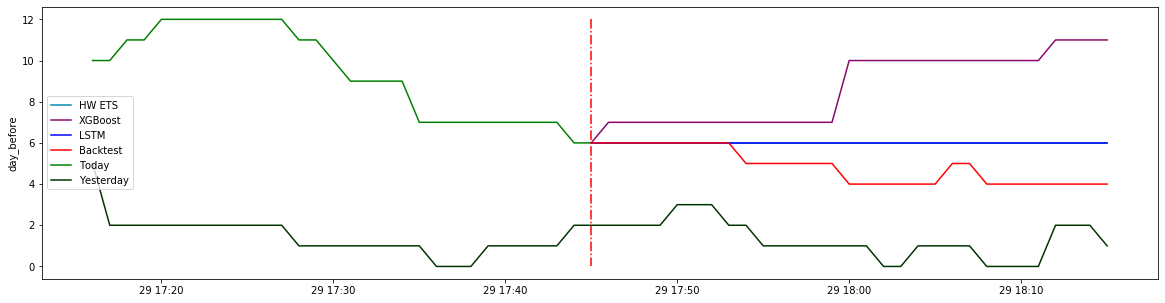

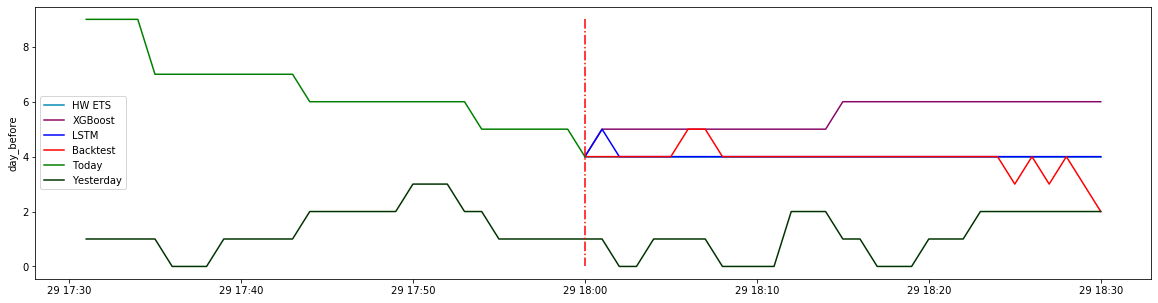

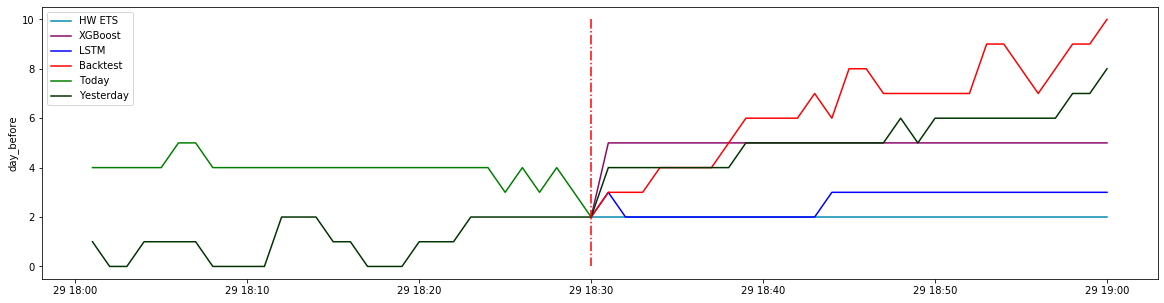

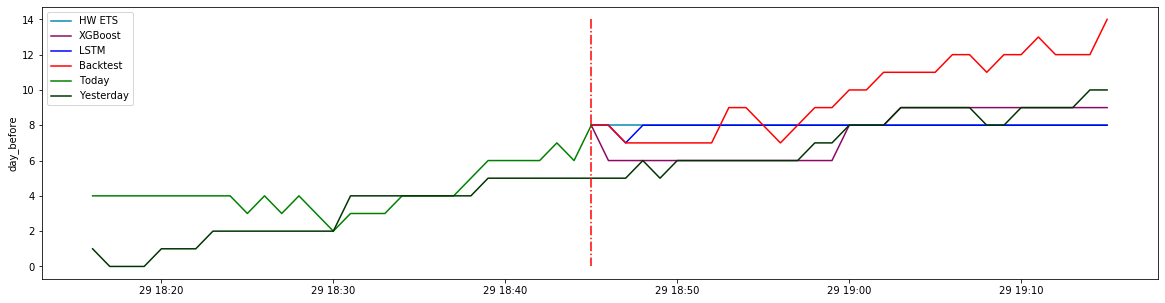

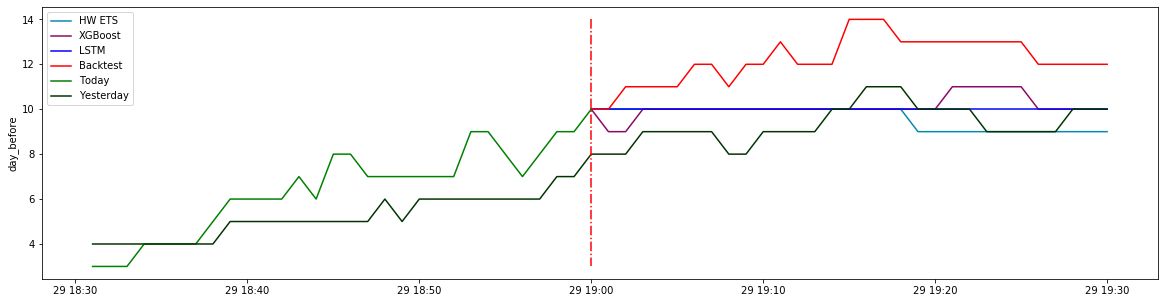

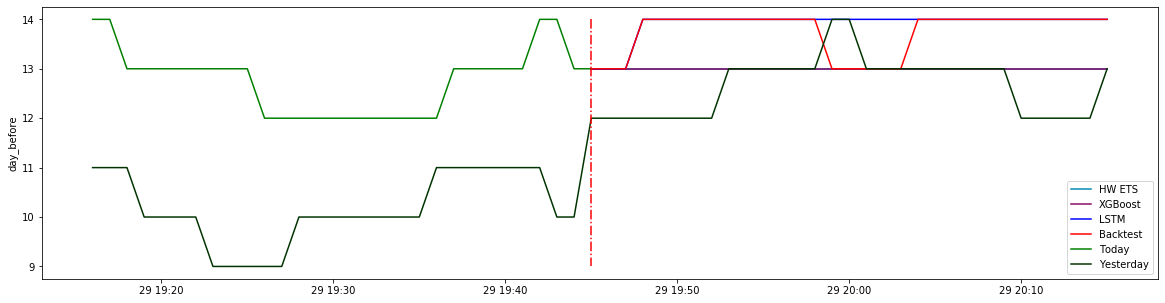

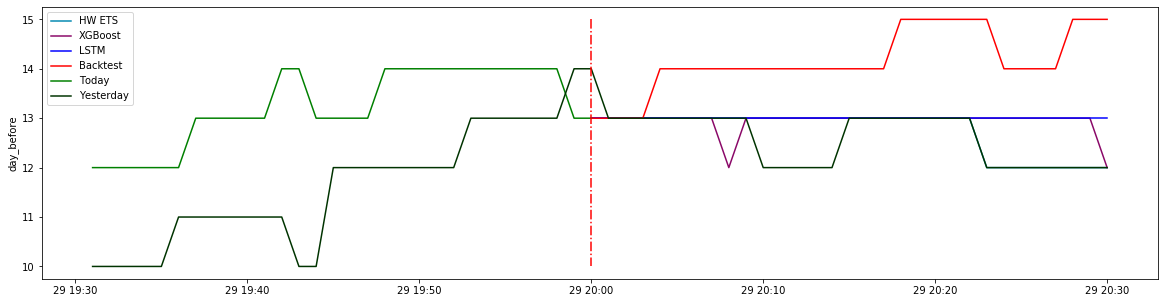

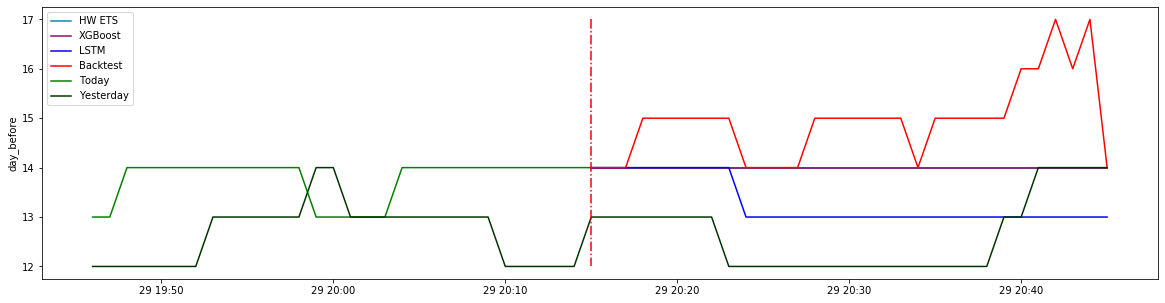

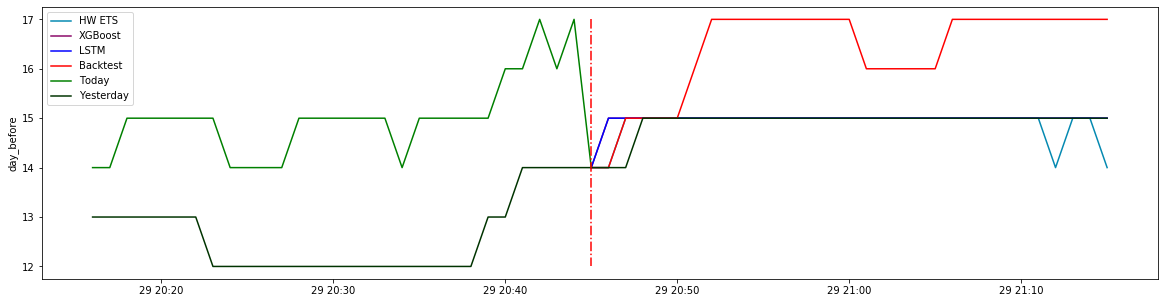

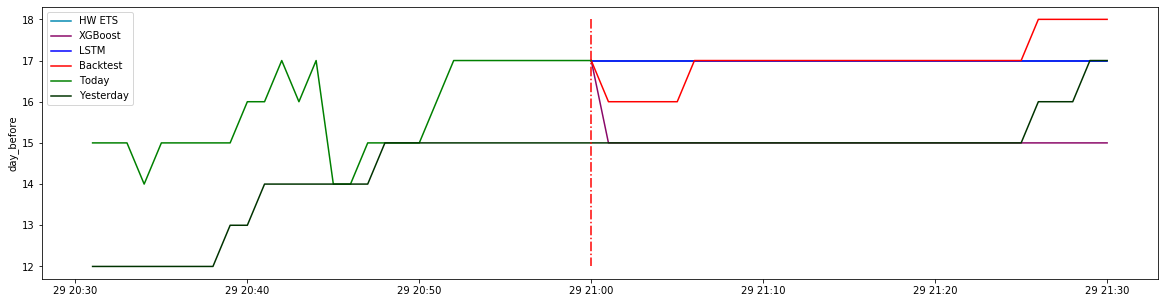

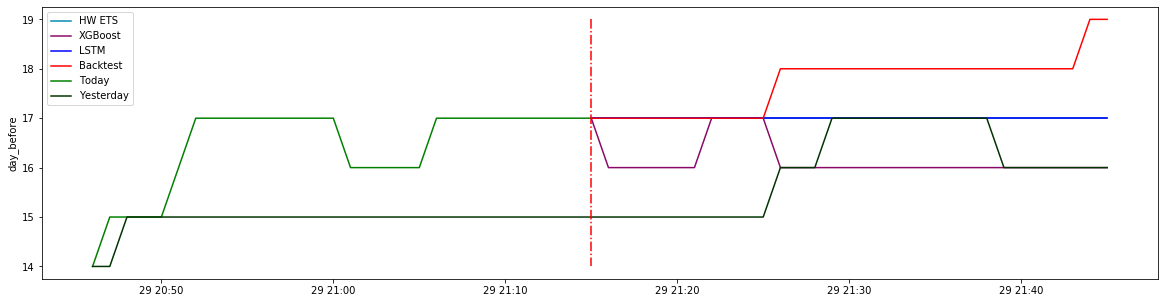

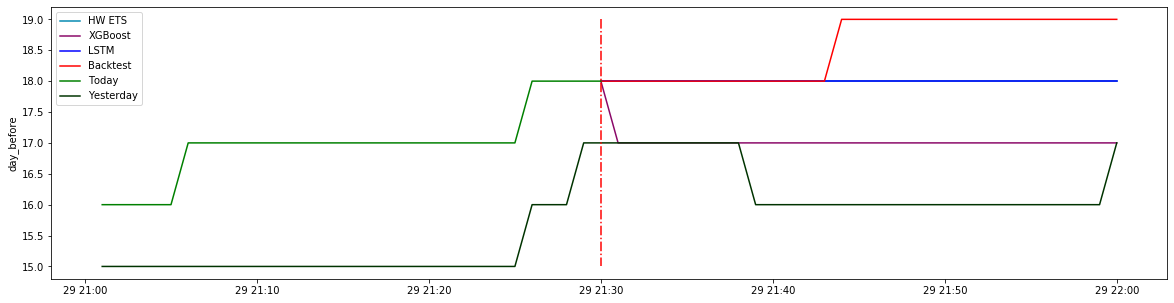

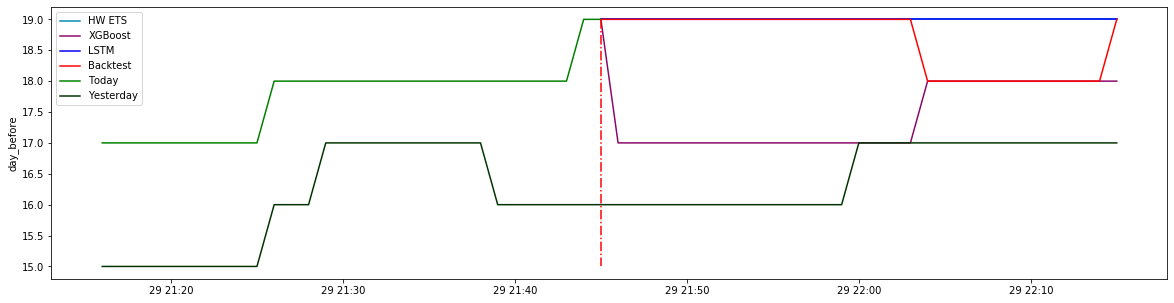

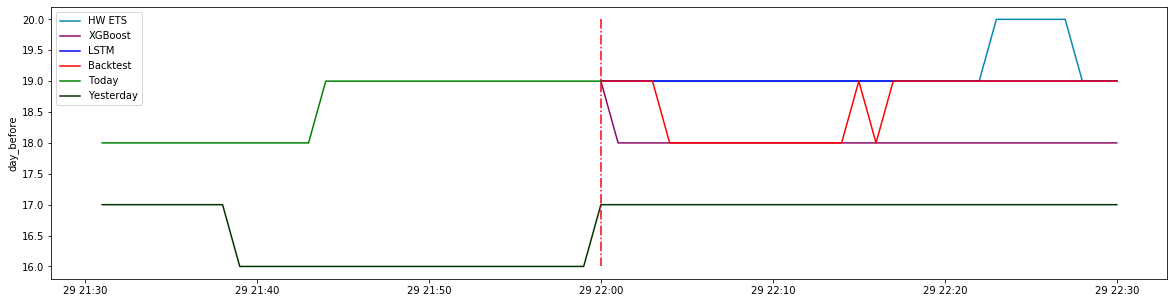

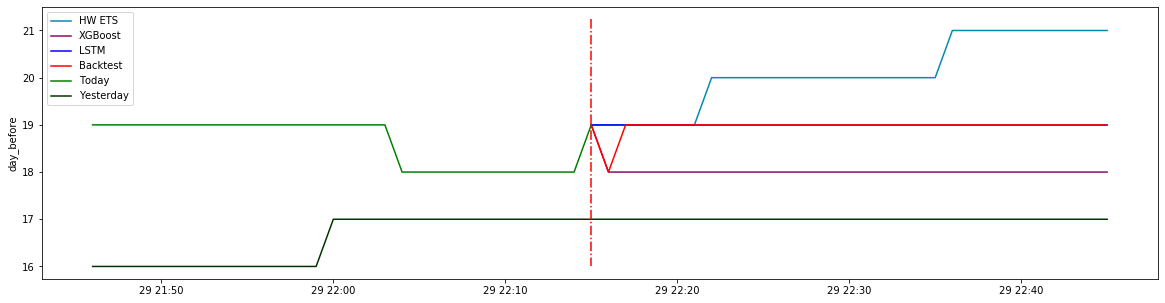

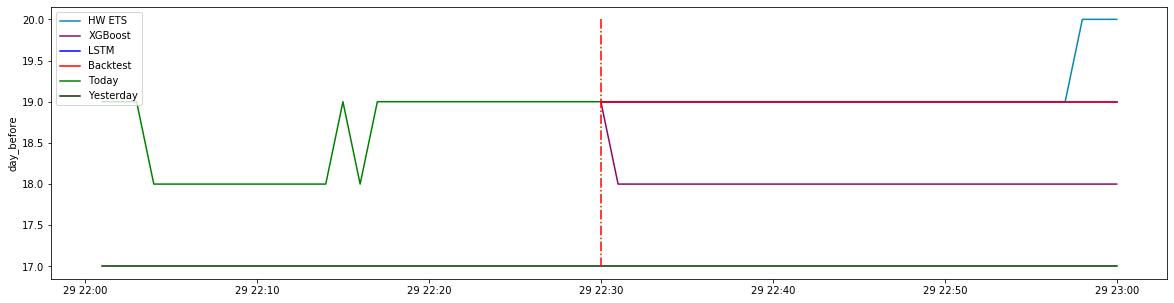

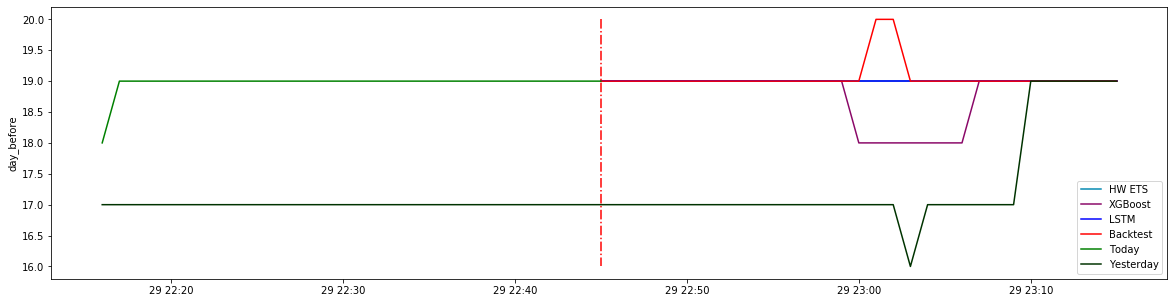

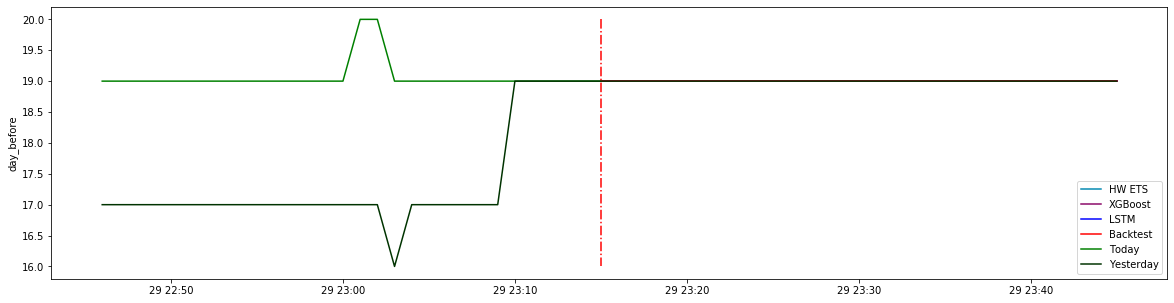

In [11]:
time_variation = 30

for i in range(df_result.hour.shape[0]):
    try:
        # Generating all availiable graphics
        time = df_result.hour[i]
        param = [df_result.t[i], df_result.d[i], df_result.s[i], df_result.p[i], df_result.b[i], df_result.r[i]]
        df_assessement_small = model_generation_viz(time, 30, param)

        # Graphic visualisation of the prediction
        lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
        #Removing actual and backtest data on projection time for better visualisation

        # Graphic visualisation of the prediction
        fig, ax = plt.subplots(figsize=(20,5))
        #    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
        ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="#0489B1",label="HW ETS")    
        ax = sns.lineplot(x=df_assessement_small.index, y="xgboost",data=df_assessement_small, color="#8A0868",label="XGBoost") 
        ax = sns.lineplot(x=df_assessement_small.index, y="lstm",data=df_assessement_small, color="blue",label="LSTM")
        ax = sns.lineplot(x=df_assessement_small.index, y="backtest",data=df_assessement_small, color="red",label="Backtest") 
        ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today")     
        ax = sns.lineplot(x=df_assessement_small.index, y="day_before",data=df_assessement_small, color="#003300",label="Yesterday")

        x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
        ax = plt.plot(x1, y1, linestyle="dashdot", color="red")

        plt.savefig('/home/exalis/GitHub/velib-prediction/velib-prediction/6. Model Assessement/images/{}.png'.format(time), dpi=fig.dpi)
    except:
        print("error at",i)